Things that are working:
- Load DeepSEA model
- Load DeepSEA example dataloader (only 10 seqs)
- Plot gradient based importance scores
- Extract filter/kernel weights
- Load test data

Things that are not working / need to be added:
- Loading train data will crash kernel
- Not sure how to create dataloader with full dataset
- Convert weights to PWMs
- Convert PWMs to seqlogos

In [2]:
# Select Environment(conda_kipoi-shared__env__kipoi-py3-keras2)
import kipoi
import torch
import scipy.io
import time
import numpy as np
import h5py

import kipoi_interpret
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation

/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/tensorflow/python/fra

In [13]:
import os
import matplotlib.pyplot as plt

In [4]:
### checks
# kipoi.list_models()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [5]:
### set the path
data_dir = 'data/deepsea_train/'
result_dir = 'out/'

### Import DeepSEA model

In [6]:
deep_sea = kipoi.get_model("DeepSEA/predict")

Using downloaded and verified file: /home/ubuntu/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


In [7]:
# print model architecture
deep_sea.model

Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15): Sigmoid()
  )
  (3): AverageRC()
)

### Check out the default dataloader
Still not sure how to create a full dataloader

In [8]:
dl = deep_sea.default_dataloader
dl2 = dl(**dl.example_kwargs)
whole_data = dl2.load_all()

/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoiseq/dataloaders/sequence.py:80: FutureWarning: read_table is deprecated, use read_csv instead.
  sep='\t')
/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoiseq/dataloaders/sequence.py:92: FutureWarning: read_table is deprecated, use read_csv instead.
  sep='\t')
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


### Gradient-based important score

In [9]:
grxinp = GradientXInput(deep_sea)

In [10]:
val = grxinp.score(whole_data["inputs"])[0]

model_architecture:69: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
model_architecture:87: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


In [24]:
val = np.squeeze(val).transpose()

<AxesSubplot:>

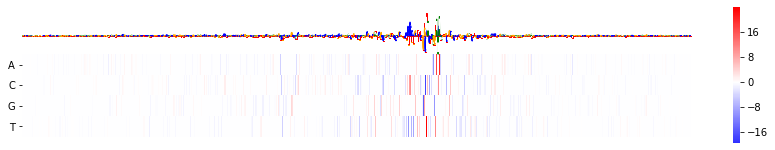

In [25]:
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

In [26]:
gr = Gradient(deep_sea)
val2 = grxinp.score(whole_data["inputs"])[0]
val2 = np.squeeze(val2).transpose()

<AxesSubplot:>

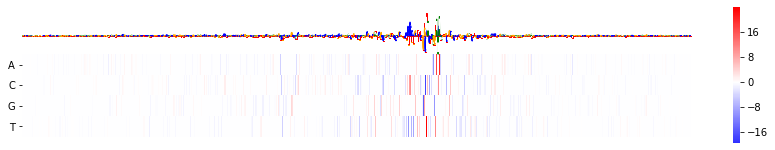

In [27]:
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val2, val2.T, ax=plt.subplot())

### Extract pretrained weights

In [5]:
weights = {}
for name, param in deep_sea.model.named_parameters():
    print('name: ', name)
    print(type(param))
    weights[name] = param
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

name:  2.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([320, 4, 1, 8])
param.requires_grad:  True
=====
name:  2.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([320])
param.requires_grad:  True
=====
name:  2.4.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([480, 320, 1, 8])
param.requires_grad:  True
=====
name:  2.4.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([480])
param.requires_grad:  True
=====
name:  2.8.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([960, 480, 1, 8])
param.requires_grad:  True
=====
name:  2.8.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([960])
param.requires_grad:  True
=====
name:  2.12.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([925, 50880])
param.requires_grad:  True
=====
name:  2.12.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([925])
param.requires_grad: 

### Load train/test dataset

In [31]:
tic = time.time()
test_mat = scipy.io.loadmat(data_dir + 'test.mat')
Y_test = torch.FloatTensor(test_mat['testdata'])
X_test = torch.FloatTensor(test_mat['testxdata'])
toc = time.time()
print(round(toc - tic), 'sec elapsed')

21 sec elapsed


In [32]:
print(X_test.shape, Y_test.shape)

torch.Size([455024, 4, 1000]) torch.Size([455024, 919])


### PWM-based filter visualizations

In [ ]:
# TODO